In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import pandas as pd
import math
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
nltk.download('words')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm,tqdm_pandas
nltk.download('brown')
from nltk.corpus import brown
from nltk.corpus import stopwords
nltk.download('stopwords')
import random

words = brown.words(categories="news")
sents = brown.sents(categories=["news"])

print("Number of words: ",len(words))
print("Number of sentences: ",len(sents))
print("Number of unique words (including capitalized)",
      len(set(words)))

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag,wordnet.NOUN)

def lemmWord(w):
    return lem.lemmatize(w,get_wordnet_pos(w))

def processCorpus(sents):
    w2id,id2w,idx={},{},2
    eng = set(nltk.corpus.words.words())
    w2id['<s>'],id2w[0]=0,'<s>'
    w2id['<e>'],id2w[1]=1,'<e>'
    newSents = []
    for sent in tqdm(sents):
        newSent = [0]
        for word in sent:
            word = word.lower()
            word = lemmWord(word)
            if word not in eng:
                continue
            if word not in w2id:
                w2id[word]=idx
                id2w[idx]=word
                idx+=1
            newSent.append(w2id[word])
        newSent.append(1)
        newSents.append(newSent)
    return w2id,id2w,newSents

lem = WordNetLemmatizer()
w2id,id2w,newSents=processCorpus(sents[:2000])
print("Number of unique words: ",len(w2id))

[nltk_data] Downloading package words to /home/yui/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yui/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /home/yui/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of words:  100554
Number of sentences:  4623


  0%|          | 0/2000 [00:00<?, ?it/s]

Number of unique words (including capitalized) 14394


100%|██████████| 2000/2000 [00:03<00:00, 646.25it/s]

Number of unique words:  3973


#### Original Matrix Factorization for User-Movie recommender system
The model is given by, 

$$\hat{r}_{ij}=w_i^\top u_j + b_i+c_j+\mu$$

where user bias $b_i$, movie bias $c_j$ and global mean $\mu$.
So the alternating least squares now become,

$$\begin{align*}
w_i&=\bigg(\sum_{j\in \Psi_i}u_ju_j^\top\bigg)^{-1}\sum_{j\in\Psi_i}(r_{ij}-b_i-c_j-\mu)u_j \\
u_j&= \bigg(\sum_{i\in\Omega_j }w_iw_i^\top\bigg)^{-1}\sum_{i\in\Omega_j}(r_{ij}-b_i-c_j-\mu)w_i \\
b_i &= \frac{1}{|\Psi_i|}\sum_{j\in\Psi_i}(r_{ij}-w_i^\top u_j-c_j-\mu)\\
c_j &= \frac{1}{|\Omega_j|}\sum_{i\in\Omega_j}(r_{ij}-w_i^\top u_j-b_i-\mu)
\end{align*}$$

Adding regularization terms into loss function, 

$$J = \sum_{i,j\in\Omega}(r_{ij}-\hat{r}_{ij})^2+\lambda \bigg(\|W\|^2_F+\|U\|_F^2+\|b\|_2^2+\|c\|_2^2\bigg)$$

Finally,

$$\begin{align*}
w_i&=\bigg(\sum_{j\in \Psi_i}u_ju_j^\top + \lambda I\bigg)^{-1}\sum_{j\in\Psi_i}(r_{ij}-b_i-c_j-\mu)u_j \\
u_j&= \bigg(\sum_{i\in\Omega_j }w_iw_i^\top+ \lambda I\bigg)^{-1}\sum_{i\in\Omega_j}(r_{ij}-b_i-c_j-\mu)w_i \\
b_i &= \frac{1}{|\Psi_i|+\lambda}\sum_{j\in\Psi_i}(r_{ij}-w_i^\top u_j-c_j-\mu)\\
c_j &= \frac{1}{|\Omega_j|+\lambda}\sum_{i\in\Omega_j}(r_{ij}-w_i^\top u_j-b_i-\mu)
\end{align*}$$

In [2]:
def weight(vec,xmax=100,alpha=.75):
    vec[vec<1]=(vec[vec<1]/xmax)**alpha
    vec[vec>=1]=1
    return vec
def log_add1(vec):
    return np.log(vec+1)

#### Matrix Factorization for Term-Term Matrix
The target matrix with elements $X_{ij}$ represent how much time word $i$ appears in context of word $j$. It is calculated as follows,
$$X_{ij}\leftarrow X_{ij}+\frac{1}{j-i}$$
Since it can lead to large value, log scale is applied. To avoid NaN value, one is added before taking the log, 

$$\log_{+1}X_{ij}=\log(X_{ij}+1)$$

A weight function is introduced to $X_{ij}$, 
$$f(X)=\big(\frac{X}{X_{max}}\big)^\alpha$$
where $\alpha=0.75$ and $X_{max}=100$.

This model is predicting log of relations, 

$$\log_{+1}X_{ij}\approx w_i^\top u_j+b_i+c_j+\mu$$

The cost function is given by, 

$$J=\sum^N_{i=1}\sum^M_{j=1}f(X_{ij})\bigg(w_i^\top u_j-\log_{+1}X_{ij}\bigg)^2$$

The alternating least squares become,

$$\begin{align*}
w_i &= \bigg(\sum_{j=1}^M f(X_{ij})u_ju_j^\top\bigg)^{-1}\sum^M_{j=1}f(X_{ij})\bigg(\log_{+1}X_{ij}-b_i-c_j-\mu\bigg)u_j \\
u_j &= \bigg(\sum_{i=1}^Nf(X_{ij})w_iw_i^\top\bigg)^{-1}\sum_{i=1}^Nf(X_{ij})\bigg(\log_{+1}X_{ij}-b_i-c_j-\mu\bigg)w_i\\
b_i &= \frac{1}{\sum^M_{j=1}f(X_{ij})} \sum^M_{j=1}f(X_{ij})\bigg(\log_{+1}X_{ij}-w_i^\top u_j-c_j-\mu\bigg)\\
c_j &= \frac{1}{\sum^N_{i=1}f(X_{ij})} \sum^N_{i=1}f(X_{ij})\bigg(\log_{+1}X_{ij}-w_i^\top u_j-b_i-\mu\bigg)
\end{align*}$$

In [3]:
class MF:
    def __init__(self,V,CS=10,k=50):
        self.CS = CS
        self.V = V
        self.k = k
        self.X = np.zeros((V,V))
        self.W = np.random.randn(V,k)
        self.U = np.random.randn(V,k)
        self.B = np.random.randn(V)
        self.C = np.random.randn(V)
        self.reg=1e-2
    def setX(self,newSents):
        for sent in tqdm(newSents):
            n = len(sent)
            for i in range(n):
                end = i+self.CS+1
                if end>n: end=n
                for j in range(i+1,end):
                    self.X[sent[i],sent[j]]+=1/(j-i)
                    self.X[sent[j],sent[i]]+=1/(j-i)
        self.fX = weight(self.X)
        self.log1X = log_add1(self.X)
        self.mu = self.log1X.mean()
    def alternatingLS(self,epochs=500):
        Js = []
        for epoch in tqdm(range(epochs)):
            for i in range(self.V):
                self.updateW(i)
                self.updateB(i)
            for j in range(self.V):
                self.updateU(j)
                self.updateC(j)
            loss = self.loss()
            Js.append(loss)
        return Js
    def updateW(self,i):
        down=self.reg*np.eye(self.k)+(self.fX[i,:]*self.U.T).dot(self.U)
        up=(self.fX[i,:]*(self.log1X[i,:]-self.B[i]-self.C-self.mu)).dot(self.U)
        self.W[i]=np.linalg.solve(down,up)
    def updateB(self,i):
        down=self.fX[i].sum()
        up=self.fX[i,:].dot(self.log1X[i,:]-self.W[i].dot(self.U.T)-self.C-self.mu)
        self.B[i]=up/down/(1+self.reg)
    def updateU(self,j):
        down=self.reg*np.eye(self.k)+(self.fX[:,j]*self.W.T).dot(self.W)
        up=(self.fX[:,j]*(self.log1X[:,j]-self.B-self.C[j]-self.mu)).dot(self.W)
        self.U[j]=np.linalg.solve(down,up)
    def updateC(self,j):
        down = self.fX[:,j].sum()
        up=self.fX[:,j].dot(self.log1X[:,j]-self.W.dot(self.U[j].T)-self.B-self.mu)
        self.C[j]=up/down/(1+self.reg)
    def loss(self):
        tmp = self.W.dot(self.U.T)+self.B.reshape(self.V,1)
        tmp+= self.C.reshape(1,self.V)+self.mu-self.log1X
        return (self.fX*tmp*tmp).sum()

In [4]:
mf = MF(len(w2id))
mf.setX(newSents)

100%|██████████| 2000/2000 [00:00<00:00, 9952.35it/s]


In [5]:
epochs = 100
Js = mf.alternatingLS(epochs=epochs)

100%|██████████| 100/100 [07:00<00:00,  4.20s/it]


Text(0, 0.5, 'loss')

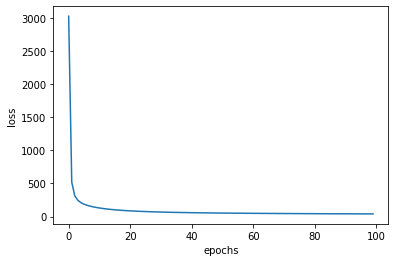

In [6]:
plt.plot(range(len(Js)),Js)
plt.xlabel("epochs")
plt.ylabel("loss")

In [7]:
from sklearn.manifold import TSNE

In [9]:
Embeddings = (mf.W+mf.U)/2
tsne = TSNE()
Z = tsne.fit_transform(Embeddings)

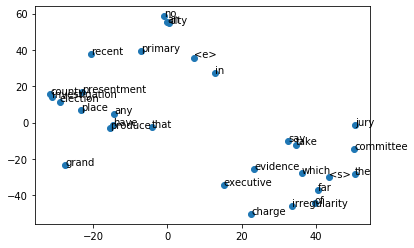

In [10]:
show = 30
plt.scatter(Z[:show,0],Z[:show,1])
for i in range(show):
    plt.annotate(s=id2w[i],xy=(Z[i,0],Z[i,1]))